In [26]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import unicodedata
import requests

In [27]:
dados = pd.read_csv('dados_limpos.csv')

In [28]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753603 entries, 0 to 753602
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            753603 non-null  int64  
 1   SP_AA            753603 non-null  int64  
 2   SP_MM            753603 non-null  int64  
 3   SP_CNES          753603 non-null  int64  
 4   SP_NAIH          753603 non-null  int64  
 5   SP_PROCREA       753603 non-null  int64  
 6   SP_DTINTER       753603 non-null  int64  
 7   SP_DTSAIDA       753603 non-null  int64  
 8   SP_ATOPROF       753603 non-null  int64  
 9   SP_VALATO        753603 non-null  float64
 10  SP_M_HOSP        753603 non-null  int64  
 11  SP_M_PAC         753603 non-null  int64  
 12  SP_DES_HOS       753603 non-null  int64  
 13  SP_DES_PAC       753603 non-null  int64  
 14  SP_QT_PROC       753603 non-null  int64  
 15  SP_CIDADE_H      753603 non-null  object 
 16  SP_CIDADE_P      751732 non-null  obje

In [29]:
nulos = dados.isnull().sum()
print(nulos)

SP_UF                 0
SP_AA                 0
SP_MM                 0
SP_CNES               0
SP_NAIH               0
SP_PROCREA            0
SP_DTINTER            0
SP_DTSAIDA            0
SP_ATOPROF            0
SP_VALATO             0
SP_M_HOSP             0
SP_M_PAC              0
SP_DES_HOS            0
SP_DES_PAC            0
SP_QT_PROC            0
SP_CIDADE_H           0
SP_CIDADE_P        1871
SP_CIDADE_P_EXT       0
SP_N_PROC             0
SP_N_ATOS             0
dtype: int64


In [30]:
municipios = pd.read_csv('municipios.csv', sep=',', encoding='utf-8')  # Verifique o separador e a codificação correta

In [31]:
dados = dados.dropna(subset=['SP_CIDADE_P'])

In [32]:
municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo_ibge   5570 non-null   int64  
 1   nome          5570 non-null   object 
 2   latitude      5570 non-null   float64
 3   longitude     5570 non-null   float64
 4   capital       5570 non-null   int64  
 5   codigo_uf     5570 non-null   int64  
 6   siafi_id      5570 non-null   int64  
 7   ddd           5570 non-null   int64  
 8   fuso_horario  5570 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 391.8+ KB


In [33]:
# Função para normalizar nomes de cidades
def normalize_city_name(name):
    if isinstance(name, str):
        return ''.join(c for c in unicodedata.normalize('NFKD', name) if not unicodedata.combining(c)).lower().strip()
    else:
        return ''

In [34]:

# Aplicar normalização às colunas relevantes
dados['SP_CIDADE_H_norm'] = dados['SP_CIDADE_H'].apply(normalize_city_name)
dados['SP_CIDADE_P_norm'] = dados['SP_CIDADE_P'].apply(normalize_city_name)
dados['SP_CIDADE_P_EXT_norm'] = dados['SP_CIDADE_P_EXT'].apply(normalize_city_name)
municipios['nome_norm'] = municipios['nome'].apply(normalize_city_name)

In [35]:
# Mesclar os DataFrames utilizando as colunas normalizadas
dados = dados.merge(municipios[['nome_norm', 'latitude', 'longitude']], how='left', left_on='SP_CIDADE_H_norm', right_on='nome_norm')
dados.rename(columns={'latitude': 'latitude_h', 'longitude': 'longitude_h'}, inplace=True)
dados.drop(columns=['SP_CIDADE_H_norm', 'nome_norm'], inplace=True)

dados = dados.merge(municipios[['nome_norm', 'latitude', 'longitude']], how='left', left_on='SP_CIDADE_P_norm', right_on='nome_norm')
dados.rename(columns={'latitude': 'latitude_p', 'longitude': 'longitude_p'}, inplace=True)
dados.drop(columns=['SP_CIDADE_P_norm', 'nome_norm'], inplace=True)

dados = dados.merge(municipios[['nome_norm', 'latitude', 'longitude']], how='left', left_on='SP_CIDADE_P_EXT_norm', right_on='nome_norm')
dados.rename(columns={'latitude': 'latitude_p_ext', 'longitude': 'longitude_p_ext'}, inplace=True)
dados.drop(columns=['SP_CIDADE_P_EXT_norm', 'nome_norm'], inplace=True)

In [36]:
# # Mesclar para 'SP_CIDADE_H'
# dados = dados.merge(municipios[['nome', 'latitude', 'longitude']],
#                     how='left', left_on='SP_CIDADE_H', right_on='nome')
# dados.rename(columns={'latitude': 'latitude_h', 'longitude': 'longitude_h'}, inplace=True)
# dados.drop(columns=['nome'], inplace=True)  # Drop a coluna auxiliar 'nome' do município
# #
# # Mesclar para 'SP_CIDADE_P'
# dados = dados.merge(municipios[['nome', 'latitude', 'longitude']],
#                     how='left', left_on='SP_CIDADE_P', right_on='nome')
# dados.rename(columns={'latitude': 'latitude_p', 'longitude': 'longitude_p'}, inplace=True)
# dados.drop(columns=['nome'], inplace=True)  # Drop a coluna auxiliar 'nome' do município

# # Mesclar para 'SP_CIDADE_P_EXT'
# dados = dados.merge(municipios[['nome', 'latitude', 'longitude']],
#                     how='left', left_on='SP_CIDADE_P_EXT', right_on='nome')
# dados.rename(columns={'latitude': 'latitude_p_ext', 'longitude': 'longitude_p_ext'}, inplace=True)
# dados.drop(columns=['nome'], inplace=True)  # Drop a coluna auxiliar 'nome' do município

# # Exibir o resultado
# print(dados.head())

In [37]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949348 entries, 0 to 949347
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            949348 non-null  int64  
 1   SP_AA            949348 non-null  int64  
 2   SP_MM            949348 non-null  int64  
 3   SP_CNES          949348 non-null  int64  
 4   SP_NAIH          949348 non-null  int64  
 5   SP_PROCREA       949348 non-null  int64  
 6   SP_DTINTER       949348 non-null  int64  
 7   SP_DTSAIDA       949348 non-null  int64  
 8   SP_ATOPROF       949348 non-null  int64  
 9   SP_VALATO        949348 non-null  float64
 10  SP_M_HOSP        949348 non-null  int64  
 11  SP_M_PAC         949348 non-null  int64  
 12  SP_DES_HOS       949348 non-null  int64  
 13  SP_DES_PAC       949348 non-null  int64  
 14  SP_QT_PROC       949348 non-null  int64  
 15  SP_CIDADE_H      949348 non-null  object 
 16  SP_CIDADE_P      949348 non-null  obje

In [38]:
nulos = dados.isnull().sum()

In [39]:
print(nulos)

SP_UF                   0
SP_AA                   0
SP_MM                   0
SP_CNES                 0
SP_NAIH                 0
SP_PROCREA              0
SP_DTINTER              0
SP_DTSAIDA              0
SP_ATOPROF              0
SP_VALATO               0
SP_M_HOSP               0
SP_M_PAC                0
SP_DES_HOS              0
SP_DES_PAC              0
SP_QT_PROC              0
SP_CIDADE_H             0
SP_CIDADE_P             0
SP_CIDADE_P_EXT         0
SP_N_PROC               0
SP_N_ATOS               0
latitude_h              0
longitude_h             0
latitude_p           3186
longitude_p          3186
latitude_p_ext     947113
longitude_p_ext    947113
dtype: int64


In [40]:
print(dados.columns)


Index(['SP_UF', 'SP_AA', 'SP_MM', 'SP_CNES', 'SP_NAIH', 'SP_PROCREA',
       'SP_DTINTER', 'SP_DTSAIDA', 'SP_ATOPROF', 'SP_VALATO', 'SP_M_HOSP',
       'SP_M_PAC', 'SP_DES_HOS', 'SP_DES_PAC', 'SP_QT_PROC', 'SP_CIDADE_H',
       'SP_CIDADE_P', 'SP_CIDADE_P_EXT', 'SP_N_PROC', 'SP_N_ATOS',
       'latitude_h', 'longitude_h', 'latitude_p', 'longitude_p',
       'latitude_p_ext', 'longitude_p_ext'],
      dtype='object')


In [41]:
dados = dados.loc[:,~dados.columns.duplicated()]


In [42]:
# Criando uma máscara booleana para identificar linhas onde a coluna SP_CIDADE_P é nula
mask = dados['latitude_p'].isnull()

# Aplicando a máscara para filtrar as linhas e selecionando as colunas desejadas para visualização
linhas_nulas = dados.loc[mask, ['SP_DES_HOS','SP_CIDADE_H', 'SP_CIDADE_P',
                             'SP_CIDADE_P_EXT', 'SP_N_PROC', 'SP_N_ATOS',
                             'latitude_h', 'longitude_h', 'latitude_p', 'longitude_p',
                             'latitude_p_ext', 'longitude_p_ext']]

# Imprimindo algumas linhas para visualização
print(linhas_nulas.head())


       SP_DES_HOS SP_CIDADE_H           SP_CIDADE_P        SP_CIDADE_P_EXT  \
18821           1  RIO GRANDE  Cidade de fora do RS  SÃO BERNARDO DO CAMPO   
18822           1  RIO GRANDE  Cidade de fora do RS  SÃO BERNARDO DO CAMPO   
18823           1  RIO GRANDE  Cidade de fora do RS  SÃO BERNARDO DO CAMPO   
18824           1  RIO GRANDE  Cidade de fora do RS  SÃO BERNARDO DO CAMPO   
18825           1  RIO GRANDE  Cidade de fora do RS  SÃO BERNARDO DO CAMPO   

                                               SP_N_PROC  \
18821  TRATAMENTO CIRURGICO DE FRATURA DA DIAFISE DO ...   
18822  TRATAMENTO CIRURGICO DE FRATURA DA DIAFISE DO ...   
18823  TRATAMENTO CIRURGICO DE FRATURA DA DIAFISE DO ...   
18824  TRATAMENTO CIRURGICO DE FRATURA DA DIAFISE DO ...   
18825  TRATAMENTO CIRURGICO DE FRATURA DA DIAFISE DO ...   

                                               SP_N_ATOS  latitude_h  \
18821  TRATAMENTO CIRURGICO DE FRATURA DA DIAFISE DO ...    -32.0349   
18822  TRATAMENTO CIRURGIC

In [43]:
# Remover duplicatas mantendo apenas a primeira ocorrência
dados = dados.drop_duplicates()

# Exibir o resultado
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949348 entries, 0 to 949347
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            949348 non-null  int64  
 1   SP_AA            949348 non-null  int64  
 2   SP_MM            949348 non-null  int64  
 3   SP_CNES          949348 non-null  int64  
 4   SP_NAIH          949348 non-null  int64  
 5   SP_PROCREA       949348 non-null  int64  
 6   SP_DTINTER       949348 non-null  int64  
 7   SP_DTSAIDA       949348 non-null  int64  
 8   SP_ATOPROF       949348 non-null  int64  
 9   SP_VALATO        949348 non-null  float64
 10  SP_M_HOSP        949348 non-null  int64  
 11  SP_M_PAC         949348 non-null  int64  
 12  SP_DES_HOS       949348 non-null  int64  
 13  SP_DES_PAC       949348 non-null  int64  
 14  SP_QT_PROC       949348 non-null  int64  
 15  SP_CIDADE_H      949348 non-null  object 
 16  SP_CIDADE_P      949348 non-null  obje

In [44]:
# Substituir NaN em latitude_p e longitude_p por "cidades de fora RS"
dados['latitude_p_ext'].fillna('cidade do RS', inplace=True)
dados['longitude_p_ext'].fillna('cidade do RS', inplace=True)

# Exibir o resultado
print(dados.head())


   SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
0     43   2023      9  2235420  4323106259714   303140151    20230812   
1     43   2023      9  2235420  4323106259714   303140151    20230812   
2     43   2023      9  2235420  4323106259714   303140151    20230812   
3     43   2023      9  2235420  4323106259714   303140151    20230812   
4     43   2023      9  2235420  4323106259714   303140151    20230812   

   SP_DTSAIDA  SP_ATOPROF  SP_VALATO  ...  SP_CIDADE_P  SP_CIDADE_P_EXT  \
0    20230814   204030153        0.0  ...   RONDA ALTA     Cidade do RS   
1    20230814   202020380        0.0  ...   RONDA ALTA     Cidade do RS   
2    20230814   202020029        0.0  ...   RONDA ALTA     Cidade do RS   
3    20230814   202010317        0.0  ...   RONDA ALTA     Cidade do RS   
4    20230814   202010473        0.0  ...   RONDA ALTA     Cidade do RS   

                                       SP_N_PROC  \
0  TRATAMENTO DE PNEUMONIAS OU INFLUENZA (GRIPE)   


/tmp/ipykernel_4223/4017210962.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['latitude_p_ext'].fillna('cidade do RS', inplace=True)
/tmp/ipykernel_4223/4017210962.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'cidade do RS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dados['latitude_p_ext'].fillna('cidade do RS', inplace=True)
/tmp/ipykernel_4223/4017210962.py:3: FutureWarning: A va

In [45]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949348 entries, 0 to 949347
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            949348 non-null  int64  
 1   SP_AA            949348 non-null  int64  
 2   SP_MM            949348 non-null  int64  
 3   SP_CNES          949348 non-null  int64  
 4   SP_NAIH          949348 non-null  int64  
 5   SP_PROCREA       949348 non-null  int64  
 6   SP_DTINTER       949348 non-null  int64  
 7   SP_DTSAIDA       949348 non-null  int64  
 8   SP_ATOPROF       949348 non-null  int64  
 9   SP_VALATO        949348 non-null  float64
 10  SP_M_HOSP        949348 non-null  int64  
 11  SP_M_PAC         949348 non-null  int64  
 12  SP_DES_HOS       949348 non-null  int64  
 13  SP_DES_PAC       949348 non-null  int64  
 14  SP_QT_PROC       949348 non-null  int64  
 15  SP_CIDADE_H      949348 non-null  object 
 16  SP_CIDADE_P      949348 non-null  obje

In [46]:
contador = dados['longitude_p_ext'].value_counts()
print(contador)

longitude_p_ext
 cidade do RS    947113
-48.5477            128
-52.6152             92
-49.5925             84
-49.722              83
                  ...  
-43.2003              3
-51.0694              3
-50.7985              3
-63.29                3
-68.7341              2
Name: count, Length: 77, dtype: int64


In [47]:
contagem_naih = dados['SP_NAIH'].nunique()

print(f"Quantidade de valores únicos na coluna SP_NAIH: {contagem_naih}")


Quantidade de valores únicos na coluna SP_NAIH: 58556


In [48]:
dados_sem_duplicatas = dados.drop_duplicates(subset=['SP_NAIH', 'SP_N_PROC'])

# Contar quantos procedimentos únicos cada paciente teve
contagem_procedimentos = dados_sem_duplicatas.groupby('SP_N_PROC')['SP_N_PROC'].size()

print(contagem_procedimentos)
valor = contagem_procedimentos.value_counts()
print(valor)

SP_N_PROC
AJUSTE MEDICAMENTOSO DE SITUACOES NEUROLOGICAS AGUDIZADAS                         104
ALARGAMENTO DA ENTRADA VAGINAL                                                      1
ALCOOLIZAÇÃO PERCUTÂNEA DE CARCINOMA HEPÁTICO                                       5
ALONGAMENTO / ENCURTAMENTO MIOTENDINOSO                                             3
ALONGAMENTO DE COLUMELA                                                             1
                                                                                 ... 
VITRECTOMIA POSTERIOR COM INFUSÃO DE PERFLUOCARBONO E ENDOLASER                    96
VITRECTOMIA POSTERIOR COM INFUSÃO DE PERFLUOCARBONO/ÓLEO DE SILICONE/ENDOLASER     75
VULVECTOMIA AMPLIADA C/ LINFADENECTOMIA EM ONCOLOGIA                                2
VULVECTOMIA SIMPLES                                                                 8
VULVECTOMIA SIMPLES POR TUMOR                                                       5
Name: SP_N_PROC, Length: 1045, dtype: int64


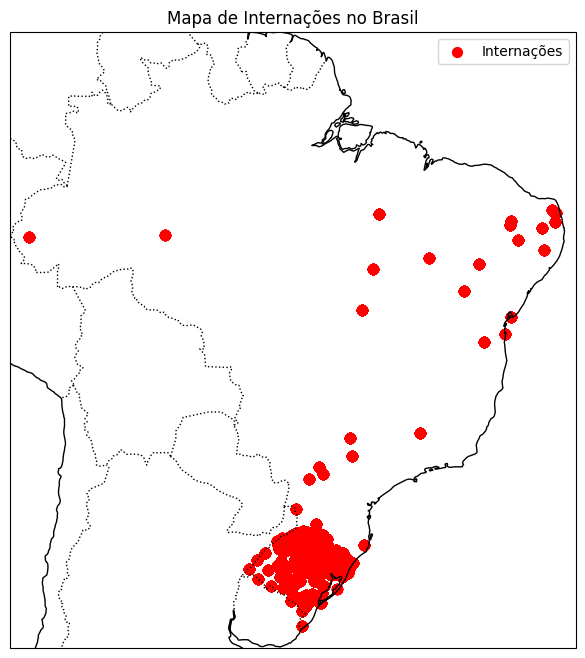

In [51]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()


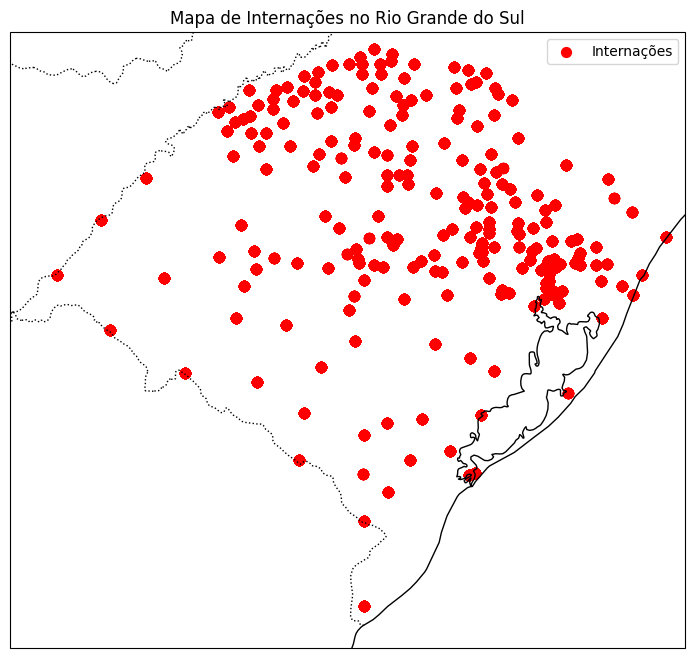

In [52]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Rio Grande do Sul (coordenadas aproximadas)
ax.set_extent([-57.65, -49.5, -34.0, -27.0], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Rio Grande do Sul')
plt.legend()
plt.show()


In [54]:
cidades_acima_menos25 = dados[dados['latitude_h'] < -25]

contagem_cidades_acima_menos25 = cidades_acima_menos25['SP_CIDADE_H'].nunique()

# Mostrar as linhas onde latitude_h está entre -25 e 0
linhas_latitude_entre_menos25_e_zero = dados[(dados['latitude_h'] > -25) & (dados['latitude_h'] <= 0)]

# Exibir os resultados
print(f"Cidades com latitude acima de -25: {contagem_cidades_acima_menos25}")
print("\nLinhas com latitude entre -25 e 0:")
print(linhas_latitude_entre_menos25_e_zero)

Cidades com latitude acima de -25: 224

Linhas com latitude entre -25 e 0:
        SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
31         43   2023      9  2235404  4323107065299   411010042    20230922   
33         43   2023      9  2235404  4323107065299   411010042    20230922   
35         43   2023      9  2235404  4323107065299   411010042    20230922   
37         43   2023      9  2235404  4323107763623   310010039    20230917   
39         43   2023      9  2235404  4323107763623   310010039    20230917   
...       ...    ...    ...      ...            ...         ...         ...   
948527     43   2023      9  2244306  4323106684908   310010047    20230828   
948529     43   2023      9  2244306  4323106684908   310010047    20230828   
948531     43   2023      9  2244306  4323106684908   310010047    20230828   
948533     43   2023      9  2244306  4323106684908   310010047    20230828   
948535     43   2023      9  2244306  4323106687394   41

In [55]:
# Filtrar as cidades com latitude acima de -25
cidades_acima_menos25 = dados[dados['latitude_h'] > -25]

# Selecionar apenas as colunas de interesse: nome da cidade e latitude
resultado = cidades_acima_menos25[['SP_CIDADE_H', 'latitude_h']]

# Exibir os resultados
print("Cidades com latitude acima de -25:")
print(resultado)


Cidades com latitude acima de -25:
        SP_CIDADE_H  latitude_h
31          SARANDI   -23.44410
33          SARANDI   -23.44410
35          SARANDI   -23.44410
37          SARANDI   -23.44410
39          SARANDI   -23.44410
...             ...         ...
948527  SANTA MARIA    -5.83802
948529  SANTA MARIA    -5.83802
948531  SANTA MARIA    -5.83802
948533  SANTA MARIA    -5.83802
948535  SANTA MARIA    -5.83802

[104940 rows x 2 columns]


In [56]:
# Filtrar as cidades com latitude acima de -25
cidades_acima_menos25 = dados[dados['latitude_h'] > -25]

# Contar o número de cidades únicas
numero_cidades_acima_menos25 = cidades_acima_menos25['SP_CIDADE_H'].nunique()

# Exibir o resultado
print(f"Número de cidades com latitude acima de -25: {numero_cidades_acima_menos25}")


Número de cidades com latitude acima de -25: 18


In [57]:
# Filtrar as cidades com latitude acima de -25
cidades_acima_menos25 = dados[dados['latitude_h'] > -25]

# Obter as informações relevantes (nome, latitude, longitude)
cidades_info = cidades_acima_menos25[['SP_CIDADE_H', 'latitude_h', 'longitude_h']].drop_duplicates()

# Exibir o resultado
print("Cidades com latitude acima de -25:")
for index, row in cidades_info.iterrows():
    print(f"Nome: {row['SP_CIDADE_H']}, Latitude: {row['latitude_h']}, Longitude: {row['longitude_h']}")


Cidades com latitude acima de -25:
Nome: SARANDI, Latitude: -23.4441, Longitude: -51.876
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -21.0342, Longitude: -49.933
Nome: MARAU, Latitude: -14.1035, Longitude: -39.0137
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -8.48668, Longitude: -36.2402
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SÃO GABRIEL, Latitude: -11.2175, Longitude: -41.8843
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SANTA MARIA, Latitude: -5.83802, Longitude: -35.6914
Nome: SÃO FRANCISCO DE PAULA, Latitude: -20.7036, Longitude: -44.9838
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35.428
Nome: VERA CRUZ, Latitude: -12.9568, Longitude: -38.6153
Nome: VERA CRUZ, Latitude: -22.2183, Longitude: -49.8207
Nome: TAPEJARA, Latitude: -23.7315, Longitude

In [58]:
# Verificar se existe a cidade "Lajeado do Bugre"
cidade_lajeado_bugre = dados[dados['SP_CIDADE_P'] == 'LAJEADO DO BUGRE']

# Exibir o resultado
if not cidade_lajeado_bugre.empty:
    print("A cidade 'Lajeado do Bugre' foi encontrada.")
else:
    print("A cidade 'Lajeado do Bugre' não foi encontrada.")


A cidade 'Lajeado do Bugre' foi encontrada.


In [59]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Filtrar as cidades fora do Rio Grande do Sul com latitude > -25
cidades_foras_rgs = dados[dados['latitude_h'] > -25]

# Criar uma lista para armazenar os resultados
resultados = []

# Iterar sobre as cidades fora do Rio Grande do Sul
for index, row in cidades_foras_rgs.iterrows():
    nome_cidade = row['SP_CIDADE_H']
    latitude_for = row['latitude_h']
    
    # Verificar se existe uma cidade com o mesmo nome e latitude < -25 no municipios.csv
    cidade_info = municipios[municipios['nome'] == nome_cidade]
    cidade_rgs = cidade_info[cidade_info['latitude'] < -25]
    
    # Se a cidade for encontrada, adicionar à lista de resultados
    if not cidade_rgs.empty:
        resultados.append((nome_cidade, latitude_for))

# Exibir os resultados
if resultados:
    print("Cidades fora do Rio Grande do Sul com latitude maior que -25 que têm cidades com o mesmo nome no RS:")
    for cidade, lat in resultados:
        print(f"{cidade} (latitude fora do RS: {lat})")
else:
    print("Não foram encontradas cidades fora do Rio Grande do Sul com latitude maior que -25 que têm cidades com o mesmo nome no RS.")


Não foram encontradas cidades fora do Rio Grande do Sul com latitude maior que -25 que têm cidades com o mesmo nome no RS.


In [60]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Filtrar as linhas correspondentes no DataFrame de municípios (sem considerar maiúsculas/minúsculas)
    cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada e se sua latitude é menor que -25
    if not cidade_info.empty:
        lat = cidade_info['latitude'].values[0]
        lon = cidade_info['longitude'].values[0]
        
        if lat < -25:  # Verifica se a latitude é menor que -25
            cidades_info.append((cidade, lat, lon))

# Exibir os resultados
print("Cidades com latitude menor que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude menor que -25:
Nome: MARAU, Latitude: -28.4498, Longitude: -52.1986
Nome: SÃO GABRIEL, Latitude: -30.3337, Longitude: -54.3217
Nome: SANTA MARIA, Latitude: -29.6868, Longitude: -53.8149
Nome: SÃO FRANCISCO DE PAULA, Latitude: -29.4404, Longitude: -50.5828
Nome: TRIUNFO, Latitude: -29.9291, Longitude: -51.7075
Nome: HUMAITÁ, Latitude: -27.5691, Longitude: -53.9695
Nome: BOM JESUS, Latitude: -26.7326, Longitude: -52.3919
Nome: CAIÇARA, Latitude: -27.2791, Longitude: -53.4257


In [61]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Filtrar as linhas correspondentes no DataFrame de municípios sem diferenciar maiúsculas de minúsculas
    cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada e se sua latitude é menor que -25
    if not cidade_info.empty:
        lat = cidade_info['latitude'].values[0]
        lon = cidade_info['longitude'].values[0]
        
        if lat < -25:  # Verifica se a latitude é menor que -25
            cidades_info.append((cidade_info['nome'].values[0], lat, lon))

# Exibir os resultados
print("Cidades com latitude menor que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude menor que -25:
Nome: Marau, Latitude: -28.4498, Longitude: -52.1986
Nome: São Gabriel, Latitude: -30.3337, Longitude: -54.3217
Nome: Santa Maria, Latitude: -29.6868, Longitude: -53.8149
Nome: São Francisco de Paula, Latitude: -29.4404, Longitude: -50.5828
Nome: Triunfo, Latitude: -29.9291, Longitude: -51.7075
Nome: Humaitá, Latitude: -27.5691, Longitude: -53.9695
Nome: Bom Jesus, Latitude: -26.7326, Longitude: -52.3919
Nome: Caiçara, Latitude: -27.2791, Longitude: -53.4257


In [62]:
# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Cidade que você quer modificar
cidade_especifica = "SARANDI"

# Novos valores de latitude e longitude
nova_latitude = -27.942
nova_longitude = -52.9231

# Alterar a latitude e longitude de todas as ocorrências da cidade específica
municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# Verificar se a alteração foi aplicada
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])


      codigo_ibge     nome  latitude  longitude  capital  codigo_uf  siafi_id  \
4936      4126256  Sarandi   -27.942   -52.9231        0         41      8461   
4937      4320107  Sarandi   -27.942   -52.9231        0         43      8903   

      ddd       fuso_horario  
4936   44  America/Sao_Paulo  
4937   54  America/Sao_Paulo  


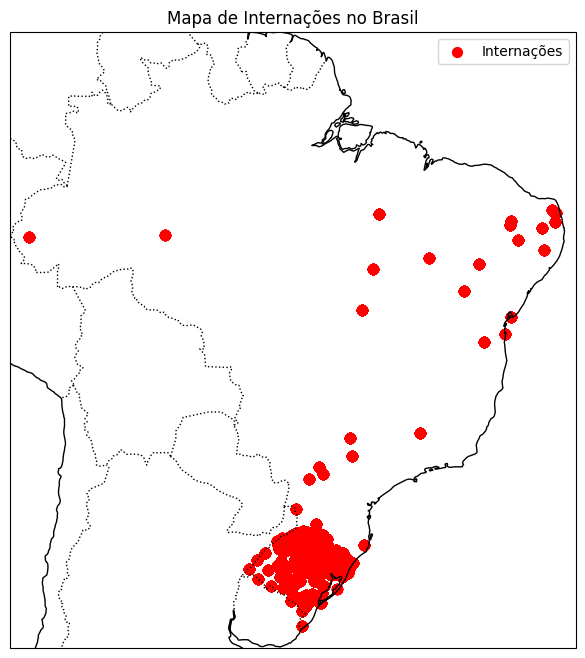

In [63]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()


In [64]:
# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Cidade que você quer modificar
cidade_especifica = "MARAU"

# Novos valores de latitude e longitude
nova_latitude = -28.4498
nova_longitude = -52.1986

# Alterar a latitude e longitude de todas as ocorrências da cidade específica
municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# Verificar se a alteração foi aplicada
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])


      codigo_ibge   nome  latitude  longitude  capital  codigo_uf  siafi_id  \
2930      4311809  Marau  -28.4498   -52.1986        0         43      8737   

      ddd       fuso_horario  
2930   54  America/Sao_Paulo  


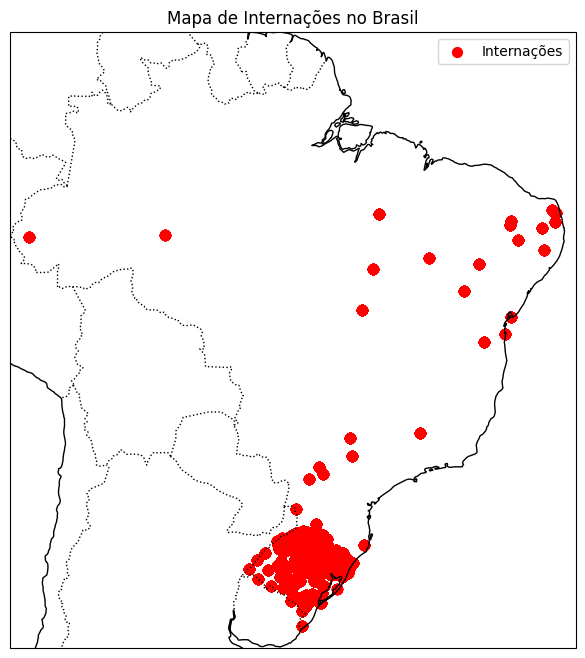

In [65]:


# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()


In [66]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Cidade que você quer modificar
cidade_especifica = "SARANDI"

# Novos valores de latitude e longitude
nova_latitude = -27.942
nova_longitude = -52.9231

# Mostrar todas as ocorrências da cidade antes da alteração
print("Antes da alteração:")
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

# Alterar a latitude e longitude de todas as ocorrências da cidade específica
municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# Mostrar todas as ocorrências da cidade após a alteração
print("\nApós a alteração:")
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])


Antes da alteração:
      codigo_ibge     nome  latitude  longitude  capital  codigo_uf  siafi_id  \
4936      4126256  Sarandi  -23.4441   -51.8760        0         41      8461   
4937      4320107  Sarandi  -27.9420   -52.9231        0         43      8903   

      ddd       fuso_horario  
4936   44  America/Sao_Paulo  
4937   54  America/Sao_Paulo  

Após a alteração:
      codigo_ibge     nome  latitude  longitude  capital  codigo_uf  siafi_id  \
4936      4126256  Sarandi   -27.942   -52.9231        0         41      8461   
4937      4320107  Sarandi   -27.942   -52.9231        0         43      8903   

      ddd       fuso_horario  
4936   44  America/Sao_Paulo  
4937   54  America/Sao_Paulo  


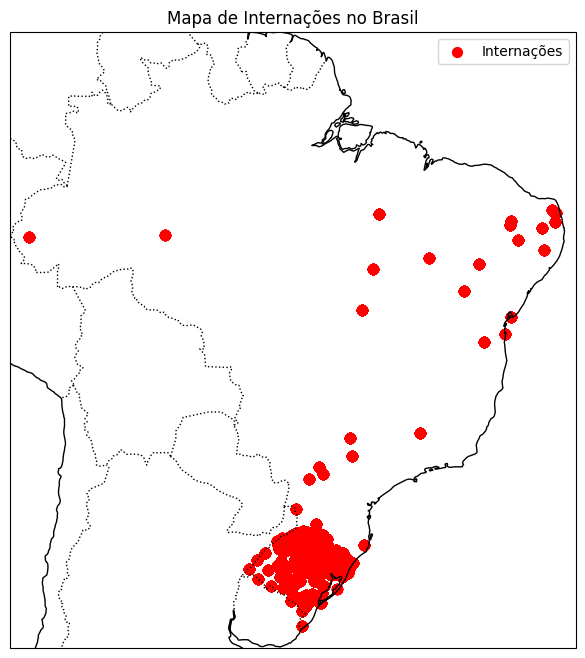

In [67]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()

In [68]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Cidade que você quer modificar
cidade_especifica = "MARAU"

# Novos valores de latitude e longitude
nova_latitude = -28.4498
nova_longitude = -52.1986

# Mostrar todas as ocorrências da cidade antes da alteração
print("Antes da alteração:")
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

# Alterar a latitude e longitude de todas as ocorrências da cidade específica
municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# Mostrar todas as ocorrências da cidade após a alteração
print("\nApós a alteração:")
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])


Antes da alteração:
      codigo_ibge   nome  latitude  longitude  capital  codigo_uf  siafi_id  \
2930      4311809  Marau  -28.4498   -52.1986        0         43      8737   

      ddd       fuso_horario  
2930   54  America/Sao_Paulo  

Após a alteração:
      codigo_ibge   nome  latitude  longitude  capital  codigo_uf  siafi_id  \
2930      4311809  Marau  -28.4498   -52.1986        0         43      8737   

      ddd       fuso_horario  
2930   54  America/Sao_Paulo  


In [69]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Filtrar as linhas correspondentes no DataFrame de municípios sem diferenciar maiúsculas de minúsculas
    cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada e se sua latitude é maior que -25
    if not cidade_info.empty:
        lat = cidade_info['latitude'].values[0]
        lon = cidade_info['longitude'].values[0]
        
        if lat > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info['nome'].values[0], lat, lon))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:
Nome: Sarandi, Latitude: -23.4441, Longitude: -51.876
Nome: Lajeado, Latitude: -9.74996, Longitude: -48.3565
Nome: Planalto, Latitude: -14.6654, Longitude: -40.4718
Nome: Soledade, Latitude: -7.05829, Longitude: -36.3668
Nome: Cachoeirinha, Latitude: -6.1156, Longitude: -47.9234
Nome: Alvorada, Latitude: -12.4785, Longitude: -49.1249
Nome: Sobradinho, Latitude: -9.45024, Longitude: -40.8145
Nome: Vera Cruz, Latitude: -6.04399, Longitude: -35.428
Nome: Tapejara, Latitude: -23.7315, Longitude: -52.8735
Nome: Cruzeiro do Sul, Latitude: -22.9624, Longitude: -52.1622


In [70]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Cidade que você quer modificar
cidade_especifica = "SARANDI"

# Novos valores de latitude e longitude
nova_latitude = -27.942
nova_longitude = -52.9231

# Mostrar todas as ocorrências da cidade antes da alteração
print("Antes da alteração:")
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

# Alterar a latitude e longitude de todas as ocorrências da cidade específica
municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# Mostrar todas as ocorrências da cidade após a alteração
print("\nApós a alteração:")
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])


Antes da alteração:
      codigo_ibge     nome  latitude  longitude  capital  codigo_uf  siafi_id  \
4936      4126256  Sarandi  -23.4441   -51.8760        0         41      8461   
4937      4320107  Sarandi  -27.9420   -52.9231        0         43      8903   

      ddd       fuso_horario  
4936   44  America/Sao_Paulo  
4937   54  America/Sao_Paulo  

Após a alteração:
      codigo_ibge     nome  latitude  longitude  capital  codigo_uf  siafi_id  \
4936      4126256  Sarandi   -27.942   -52.9231        0         41      8461   
4937      4320107  Sarandi   -27.942   -52.9231        0         43      8903   

      ddd       fuso_horario  
4936   44  America/Sao_Paulo  
4937   54  America/Sao_Paulo  


In [71]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Filtrar as linhas correspondentes no DataFrame de municípios sem diferenciar maiúsculas de minúsculas
    cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada e se sua latitude é maior que -25
    if not cidade_info.empty:
        lat = cidade_info['latitude'].values[0]
        lon = cidade_info['longitude'].values[0]
        
        if lat > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info['nome'].values[0], lat, lon))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:
Nome: Sarandi, Latitude: -23.4441, Longitude: -51.876
Nome: Lajeado, Latitude: -9.74996, Longitude: -48.3565
Nome: Planalto, Latitude: -14.6654, Longitude: -40.4718
Nome: Soledade, Latitude: -7.05829, Longitude: -36.3668
Nome: Cachoeirinha, Latitude: -6.1156, Longitude: -47.9234
Nome: Alvorada, Latitude: -12.4785, Longitude: -49.1249
Nome: Sobradinho, Latitude: -9.45024, Longitude: -40.8145
Nome: Vera Cruz, Latitude: -6.04399, Longitude: -35.428
Nome: Tapejara, Latitude: -23.7315, Longitude: -52.8735
Nome: Cruzeiro do Sul, Latitude: -22.9624, Longitude: -52.1622


In [73]:
print(dados.columns)


Index(['SP_UF', 'SP_AA', 'SP_MM', 'SP_CNES', 'SP_NAIH', 'SP_PROCREA',
       'SP_DTINTER', 'SP_DTSAIDA', 'SP_ATOPROF', 'SP_VALATO', 'SP_M_HOSP',
       'SP_M_PAC', 'SP_DES_HOS', 'SP_DES_PAC', 'SP_QT_PROC', 'SP_CIDADE_H',
       'SP_CIDADE_P', 'SP_CIDADE_P_EXT', 'SP_N_PROC', 'SP_N_ATOS',
       'latitude_h', 'longitude_h', 'latitude_p', 'longitude_p',
       'latitude_p_ext', 'longitude_p_ext'],
      dtype='object')


In [74]:
print(dados.tail)


<bound method NDFrame.tail of         SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
0          43   2023      9  2235420  4323106259714   303140151    20230812   
1          43   2023      9  2235420  4323106259714   303140151    20230812   
2          43   2023      9  2235420  4323106259714   303140151    20230812   
3          43   2023      9  2235420  4323106259714   303140151    20230812   
4          43   2023      9  2235420  4323106259714   303140151    20230812   
...       ...    ...    ...      ...            ...         ...         ...   
949343     43   2023      9  2232022  4323104173168   303130067    20230522   
949344     43   2023      9  2232022  4323104173168   303130067    20230522   
949345     43   2023      9  2232022  4323104173168   303130067    20230522   
949346     43   2023      9  2232022  4323104173168   303130067    20230522   
949347     43   2023      9  2232022  4323104173168   303130067    20230522   

        SP_DTSAIDA  S

In [75]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SARANDI"

# Novos valores de latitude e longitude
nova_latitude = -27.942
nova_longitude = -52.9231

# Mostrar as ocorrências da cidade em 'SP_CIDADE_H' antes da alteração
print("Antes da alteração (SP_CIDADE_H):")
print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# Mostrar as ocorrências da cidade em 'SP_CIDADE_P' antes da alteração
print("\nAntes da alteração (SP_CIDADE_P):")
print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

# Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_H'
print("\nApós a alteração (SP_CIDADE_H):")
print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_P'
print("\nApós a alteração (SP_CIDADE_P):")
print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])


Antes da alteração (SP_CIDADE_H):
        SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
31         43   2023      9  2235404  4323107065299   411010042    20230922   
32         43   2023      9  2235404  4323107065299   411010042    20230922   
33         43   2023      9  2235404  4323107065299   411010042    20230922   
34         43   2023      9  2235404  4323107065299   411010042    20230922   
35         43   2023      9  2235404  4323107065299   411010042    20230922   
...       ...    ...    ...      ...            ...         ...         ...   
939048     43   2023      9  2235404  4323106968631   303040017    20230909   
939049     43   2023      9  2235404  4323106968664   303070102    20230805   
939050     43   2023      9  2235404  4323106968664   303070102    20230805   
939051     43   2023      9  2235404  4323106968664   303070102    20230805   
939052     43   2023      9  2235404  4323106968664   303070102    20230805   

        SP_DTSAID

In [76]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35.428
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35.428
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.16

In [77]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "PLANALTO"

# Novos valores de latitude e longitude
nova_latitude = -27.3297
nova_longitude = -53.0575

# Mostrar as ocorrências da cidade em 'SP_CIDADE_H' antes da alteração
print("Antes da alteração (SP_CIDADE_H):")
print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# Mostrar as ocorrências da cidade em 'SP_CIDADE_P' antes da alteração
print("\nAntes da alteração (SP_CIDADE_P):")
print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

# Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_H'
print("\nApós a alteração (SP_CIDADE_H):")
print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_P'
print("\nApós a alteração (SP_CIDADE_P):")
print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])


Antes da alteração (SP_CIDADE_H):
        SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
4463       43   2023      9  2228556  4323107057401   303010061    20230911   
4464       43   2023      9  2228556  4323107057401   303010061    20230911   
4465       43   2023      9  2228556  4323107057401   303010061    20230911   
4466       43   2023      9  2228556  4323107057401   303010061    20230911   
4467       43   2023      9  2228556  4323107057401   303010061    20230911   
...       ...    ...    ...      ...            ...         ...         ...   
843230     43   2023      9  2228556  4323105031289   303040254    20230826   
843231     43   2023      9  2228556  4323105031289   303040254    20230826   
843232     43   2023      9  2228556  4323105031289   303040254    20230826   
843233     43   2023      9  2228556  4323105031289   303040254    20230826   
843234     43   2023      9  2228556  4323105031289   303040254    20230826   

        SP_DTSAID

In [78]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35.428
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35.428
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622


In [79]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "VERA CRUZ"

# Novos valores de latitude e longitude
nova_latitude = -29.7184
nova_longitude = -52.5152

# Mostrar as ocorrências da cidade em 'SP_CIDADE_H' antes da alteração
print("Antes da alteração (SP_CIDADE_H):")
print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# Mostrar as ocorrências da cidade em 'SP_CIDADE_P' antes da alteração
print("\nAntes da alteração (SP_CIDADE_P):")
print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

# Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_H'
print("\nApós a alteração (SP_CIDADE_H):")
print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_P'
print("\nApós a alteração (SP_CIDADE_P):")
print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])


Antes da alteração (SP_CIDADE_H):
        SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
225622     43   2023      9  2236354  4323106147140   305020056    20230910   
225623     43   2023      9  2236354  4323106147140   305020056    20230910   
225624     43   2023      9  2236354  4323106147140   305020056    20230910   
225625     43   2023      9  2236354  4323106147140   305020056    20230910   
225626     43   2023      9  2236354  4323106147140   305020056    20230910   
...       ...    ...    ...      ...            ...         ...         ...   
913224     43   2023      9  2236354  4323106147690   303010061    20230917   
913225     43   2023      9  2236354  4323106147690   303010061    20230917   
913226     43   2023      9  2236354  4323106147690   303010061    20230917   
913227     43   2023      9  2236354  4323106147690   303010061    20230917   
913228     43   2023      9  2236354  4323106147690   303010061    20230917   

        SP_DTSAID

In [80]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622


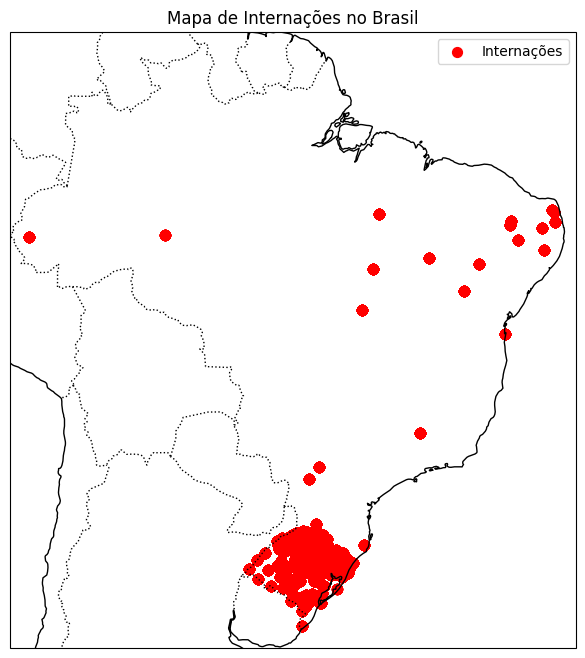

In [81]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()

In [84]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "LAJEADO"

# Novos valores de latitude e longitude
nova_latitude = -29.4591
nova_longitude = -51.9644



# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [85]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622


In [86]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SOLEDADE"

# Novos valores de latitude e longitude
nova_latitude = -28.8306
nova_longitude = -52.5131


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [87]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "CACHOEIRINHA"

# Novos valores de latitude e longitude
nova_latitude = -29.9472
nova_longitude = -51.1016


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [88]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "ALVORADA"

# Novos valores de latitude e longitude
nova_latitude = -29.9914
nova_longitude = -51.0809


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [89]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SOBRADINHO"

# Novos valores de latitude e longitude
nova_latitude = -29.4194
nova_longitude = -53.0326


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [90]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "TAPEJARA"

# Novos valores de latitude e longitude
nova_latitude = -28.0652
nova_longitude = -52.0097


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [91]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "CRUZEIRO DO SUL"

# Novos valores de latitude e longitude
nova_latitude = -29.5148
nova_longitude = -51.9928


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [92]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25:


In [96]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
    # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
    if row['latitude_h'] > -25:
        cidades_info.add((row['SP_CIDADE_H'], row['latitude_h'], row['longitude_h']))

   


# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25 (únicas):
Nome: SÃO GABRIEL, Latitude: -11.2175, Longitude: -41.8843
Nome: HUMAITÁ, Latitude: -7.51171, Longitude: -63.0327
Nome: BOM JESUS, Latitude: -5.98648, Longitude: -35.5792
Nome: SANTA MARIA, Latitude: -5.83802, Longitude: -35.6914
Nome: SÃO FRANCISCO DE PAULA, Latitude: -20.7036, Longitude: -44.9838
Nome: TRIUNFO, Latitude: -7.83272, Longitude: -38.0978
Nome: BOM JESUS, Latitude: -6.81601, Longitude: -38.6453
Nome: BOM JESUS, Latitude: -9.07124, Longitude: -44.359
Nome: TRIUNFO, Latitude: -6.5713, Longitude: -38.5986
Nome: CAIÇARA, Latitude: -6.62115, Longitude: -35.4581
Nome: MARAU, Latitude: -14.1035, Longitude: -39.0137


In [97]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
 
    # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
    if row['latitude_p'] > -25:
        cidades_info.add((row['SP_CIDADE_P'], row['latitude_p'], row['longitude_p']))



# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25 (únicas):
Nome: SÃO FRANCISCO DE PAULA, Latitude: -20.7036, Longitude: -44.9838
Nome: INDEPENDÊNCIA, Latitude: -5.38789, Longitude: -40.3085
Nome: COLORADO, Latitude: -22.8374, Longitude: -51.9743
Nome: BOM JESUS, Latitude: -6.81601, Longitude: -38.6453
Nome: TRIUNFO, Latitude: -6.5713, Longitude: -38.5986
Nome: CAIÇARA, Latitude: -6.62115, Longitude: -35.4581
Nome: COLINAS, Latitude: -6.03199, Longitude: -44.2543
Nome: SANTA MARIA, Latitude: -5.83802, Longitude: -35.6914
Nome: TRIUNFO, Latitude: -7.83272, Longitude: -38.0978
Nome: NOVA SANTA RITA, Latitude: -8.09707, Longitude: -42.0471
Nome: JACUTINGA, Latitude: -22.286, Longitude: -46.6166
Nome: SÃO GABRIEL, Latitude: -11.2175, Longitude: -41.8843
Nome: ALTO ALEGRE, Latitude: 2.98858, Longitude: -61.3072
Nome: HUMAITÁ, Latitude: -7.51171, Longitude: -63.0327
Nome: TAVARES, Latitude: -7.62697, Longitude: -37.8712
Nome: BOM JESUS, Latitude: -9.07124, Longitude: -44.359
Nome: CENTENÁRIO, Latitude: -8.

In [98]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SÃO GABRIEL"

# Novos valores de latitude e longitude
nova_latitude = -30.3337
nova_longitude = -54.3217


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [99]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "HUMAITÁ"

# Novos valores de latitude e longitude
nova_latitude = -27.5691
nova_longitude = -53.9695


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [100]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "BOM JESUS"

# Novos valores de latitude e longitude
nova_latitude = -28.6697
nova_longitude = -50.4295


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [101]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SANTA MARIA"

# Novos valores de latitude e longitude
nova_latitude = -29.6868
nova_longitude = -53.8149


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [102]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SÃO FRANCISCO DE PAULA"

# Novos valores de latitude e longitude
nova_latitude = -29.4404
nova_longitude = -50.5828


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [103]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "TRIUNFO"

# Novos valores de latitude e longitude
nova_latitude = -29.9291
nova_longitude = -51.7075


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [104]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "BOM JESUS"

# Novos valores de latitude e longitude
nova_latitude = -28.6697
nova_longitude = -50.4295


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [105]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "CAIÇARA"

# Novos valores de latitude e longitude
nova_latitude = -27.2791
nova_longitude = -53.4257


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [106]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "MARAU"

# Novos valores de latitude e longitude
nova_latitude = -28.4498
nova_longitude = -52.1986


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [107]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
    # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
    if row['latitude_h'] > -25:
        cidades_info.add((row['SP_CIDADE_H'], row['latitude_h'], row['longitude_h']))

   


# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25 (únicas):


In [108]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
 
    # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
    if row['latitude_p'] > -25:
        cidades_info.add((row['SP_CIDADE_P'], row['latitude_p'], row['longitude_p']))



# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25 (únicas):
Nome: ALTO ALEGRE, Latitude: 2.98858, Longitude: -61.3072
Nome: COLINAS, Latitude: -6.03199, Longitude: -44.2543
Nome: TAVARES, Latitude: -7.62697, Longitude: -37.8712
Nome: INDEPENDÊNCIA, Latitude: -5.38789, Longitude: -40.3085
Nome: COLORADO, Latitude: -22.8374, Longitude: -51.9743
Nome: ALTO ALEGRE, Latitude: -21.5811, Longitude: -50.168
Nome: NOVA SANTA RITA, Latitude: -8.09707, Longitude: -42.0471
Nome: JACUTINGA, Latitude: -22.286, Longitude: -46.6166
Nome: CENTENÁRIO, Latitude: -8.96103, Longitude: -47.3304


In [109]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "ALTO ALEGRE"

# Novos valores de latitude e longitude
nova_latitude = -28.7769
nova_longitude = -52.9893


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [110]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "COLINAS"

# Novos valores de latitude e longitude
nova_latitude = -29.3948
nova_longitude = -51.8556


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [111]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "TAVARES"

# Novos valores de latitude e longitude
nova_latitude = -31.2843
nova_longitude = -51.0880


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [112]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "INDEPENDÊNCIA"

# Novos valores de latitude e longitude
nova_latitude = -27.8354
nova_longitude = -54.1886


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [113]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "COLORADO"

# Novos valores de latitude e longitude
nova_latitude = -28.5258
nova_longitude = -52.9928


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [114]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "NOVA SANTA RITA"

# Novos valores de latitude e longitude
nova_latitude = -29.8525
nova_longitude = -51.2837


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [115]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "JACUTINGA"

# Novos valores de latitude e longitude
nova_latitude = -27.7291
nova_longitude = -52.5372


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [117]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "CENTENÁRIO"

# Novos valores de latitude e longitude
nova_latitude = -27.7615
nova_longitude = -51.9984


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [118]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
 
    # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
    if row['latitude_p'] > -25:
        cidades_info.add((row['SP_CIDADE_P'], row['latitude_p'], row['longitude_p']))



# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25 (únicas):


In [119]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
    # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
    if row['latitude_h'] > -25:
        cidades_info.add((row['SP_CIDADE_H'], row['latitude_h'], row['longitude_h']))

   


# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")


Cidades com latitude maior que -25 (únicas):


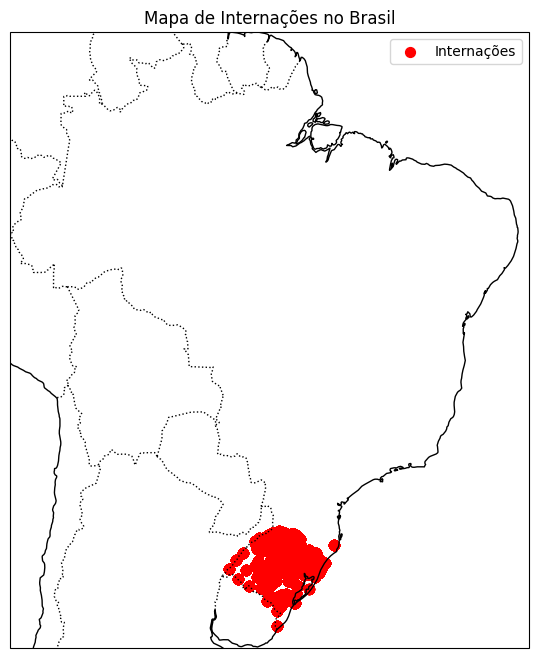

In [120]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()

In [123]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Converter colunas de latitude e longitude para numérico, forçando erros a NaN
dados['latitude_h'] = pd.to_numeric(dados['latitude_h'], errors='coerce')
dados['longitude_h'] = pd.to_numeric(dados['longitude_h'], errors='coerce')
dados['latitude_p'] = pd.to_numeric(dados['latitude_p'], errors='coerce')
dados['longitude_p'] = pd.to_numeric(dados['longitude_p'], errors='coerce')

# Verificar se a coluna 'latitude_p_ext' existe e converter se necessário
if 'latitude_p_ext' in dados.columns:
    dados['latitude_p_ext'] = pd.to_numeric(dados['latitude_p_ext'], errors='coerce')
    dados['longitude_p_ext'] = pd.to_numeric(dados['longitude_p_ext'], errors='coerce')

# Inicializar variáveis para armazenar a cidade com a maior longitude
maior_longitude = float('-inf')  # Menor infinito
cidade_com_maior_longitude = None
latitude_maior = None

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
    # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
    if row['latitude_h'] > -25 and row['longitude_h'] > maior_longitude:
        maior_longitude = row['longitude_h']
        cidade_com_maior_longitude = row['SP_CIDADE_H']
        latitude_maior = row['latitude_h']

    # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
    if row['latitude_p'] > -25 and row['longitude_p'] > maior_longitude:
        maior_longitude = row['longitude_p']
        cidade_com_maior_longitude = row['SP_CIDADE_P']
        latitude_maior = row['latitude_p']

    # Verificar 'SP_CIDADE_P_EXT', 'latitude_p_ext', 'longitude_p_ext' se houver
    if 'latitude_p_ext' in dados.columns and row['latitude_p_ext'] > -25 and row['longitude_p_ext'] > maior_longitude:
        maior_longitude = row['longitude_p_ext']
        cidade_com_maior_longitude = row['SP_CIDADE_P_EXT']
        latitude_maior = row['latitude_p_ext']

# Exibir a cidade com a maior longitude
if cidade_com_maior_longitude:
    print(f"A cidade com a maior longitude é: {cidade_com_maior_longitude}, Longitude: {maior_longitude}, Latitude: {latitude_maior}")
else:
    print("Nenhuma cidade com latitude maior que -25 foi encontrada.")


A cidade com a maior longitude é: SOLEDADE, Longitude: -36.3668, Latitude: -7.05829


In [124]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SOLEDADE"

# Novos valores de latitude e longitude
nova_latitude = -28.8306
nova_longitude = -52.5131


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



In [127]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar uma lista para armazenar as cidades com longitude maior que -49
cidades_longitude_maior_49 = []

# Iterar sobre as linhas do DataFrame para encontrar cidades com longitude maior que -49
for index, row in dados.iterrows():
    if row['longitude_h'] > -49:  # Verifica se a longitude é maior que -49
        cidades_longitude_maior_49.append(row['SP_CIDADE_H'])

# Obter apenas os nomes únicos das cidades
cidades_longitude_maior_49_unicas = list(set(cidades_longitude_maior_49))

# Exibir os resultados
print("Cidades com longitude maior que -49:")
for cidade in cidades_longitude_maior_49_unicas:
    print(cidade)


Cidades com longitude maior que -49:
SÃO MARTINHO


In [128]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Cidade que você quer modificar
cidade_especifica = "SÃO MARTINHO"

# Novos valores de latitude e longitude
nova_latitude = -27.7112
nova_longitude = -53.9699


# Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]



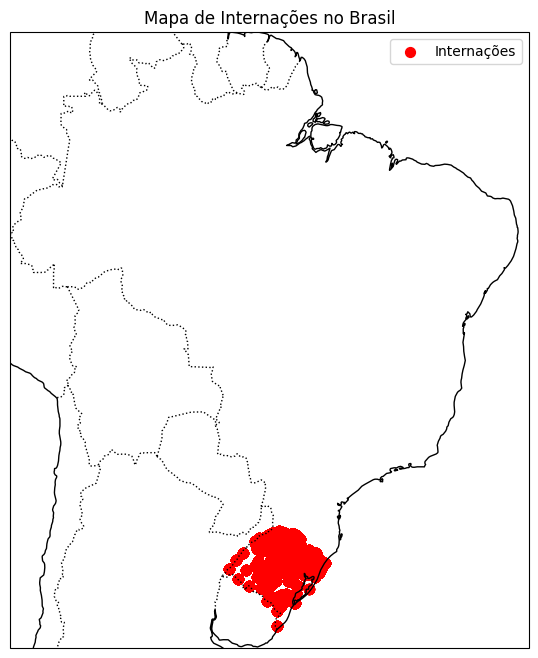

In [129]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Criar geometrias do tipo Point usando latitude e longitude
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# Criar um GeoDataFrame a partir do DataFrame e das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Brasil
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()

In [130]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um arquivo CSV chamado 'dados_RS.csv'
dados.to_csv('dados_RS.csv', index=False)

print("Arquivo 'dados_RS.csv' criado com sucesso!")


Arquivo 'dados_RS.csv' criado com sucesso!
